# 0. 라이브러리 임포트

In [18]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

# 0. 데이터로딩 및 사전작업 함수

In [19]:
# 로이터 뉴스 데이터 로딩 = num_words 지정하기
def get_reuters_load_data(num_words) : 
    # 로이터 뉴스 데이터 로딩
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words = num_words, test_split=0.2)
    
    # 원본 뉴스 데이터로 복원
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    
    # index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣기
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
      index_to_word[index]=token
    
    # 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환
    decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded.append(t)

    x_train = decoded
    
    test_decoded = []

    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        test_decoded.append(t)

    x_test = test_decoded

    
    return (x_train, y_train), (x_test, y_test) , word_index
# end of def get_reuters_load_data

# 0. 벡터화 함수

In [20]:
def transform_vector(x_train, x_test):
    # Document Term Matrix, DTM은 사이킷런의 CountVectorizer()를 통해서 생성
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)
    print(x_train_dtm.shape)
    
    # TF-IDF Matrix는 사이킷런의 TfidfTransformer()를 통해서 생성 . dtm을 받는다.
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    print(tfidfv.shape)
    
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    
    return tfidfv, tfidfv_test
# end def transform_vector

# 0.머신러닝 모델 학습 함수

In [21]:

# 머신러닝 모델 돌리기

def run_model_learn(tfidfv, tfidfv_test, y_train, y_test): 
    # 1. 나이브베이즈분류기
    nb = MultinomialNB()
    nb.fit(tfidfv, y_train)
    predicted = nb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("MultinomialNB : 나이브베이즈 - 정확도 : ", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    
    # 2. 컴포넌트 나이브베이즈분류기
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("ComplementNB : 컴포넌트 나이브베이즈 - 정확도: ", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    
    # 3. 로지스틱 회귀
    lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
    lr.fit(tfidfv, y_train)
    predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("LogisticRegression : 로지스틱회귀 - 정확도 : ", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    
    # 4. 선형 서포트벡터 머신
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
    lsvc.fit(tfidfv, y_train)
    predicted_svc = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("LinearSVC : 선형 서포트벡터 머신 - 정확도: ", accuracy_score(y_test, predicted_svc)) #예측값과 실제값 비교
    
    # 5. 결정트리
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("DecisionTreeClassifier : 결정트리 - 정확도: ", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    
    # 6. 랜덤포레스트
    forest = RandomForestClassifier(random_state=0 , n_estimators = 5)
    forest.fit(tfidfv, y_train)
    predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("RandomForestClassifier : 랜덤포레스트 - 정확도: ", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    
    # 7.그래디언트 부스팅 트리
    grbt = GradientBoostingClassifier(random_state=0) # verbose=3
    grbt.fit(tfidfv, y_train)
    predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("GradientBoostingClassifier : 그라디언트부스팅 - 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    
    # 8. 보팅 : 선형서포트벡터머신이 그라디언트부스팅 보다 조금더 높게 나오지만, predict_proba 를 제공하지 않으므로, soft voting 사용 불가.
    clf1 = LogisticRegression(random_state=0, penalty='l2')
    clf2 = ComplementNB()
    clf3 = GradientBoostingClassifier(random_state=0, verbose=3)

    voting_classifier =  VotingClassifier(estimators=[('lr', clf1), ('nb', clf2), ('gb', clf3)]
                                          , voting='soft')
    voting_classifier.fit(tfidfv, y_train)
    predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("VotingClassifier : 보팅 - 로지스틱회귀/CNB/그라디언트부스팅  - 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    
# end of def run_model_learn




# 1. 모든 단어 사용

In [22]:
(x_train, y_train), (x_test, y_test), word_index = get_reuters_load_data(None)

In [23]:
tfidfv, tfidfv_test = transform_vector(x_train, x_test)

(8982, 26506)
(8982, 26506)


In [24]:
run_model_learn(tfidfv, tfidfv_test, y_train, y_test)

MultinomialNB : 나이브베이즈 - 정확도 :  0.5997328584149599
ComplementNB : 컴포넌트 나이브베이즈 - 정확도:  0.7649154051647373
LogisticRegression : 로지스틱회귀 - 정확도 :  0.8165627782724845


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC : 선형 서포트벡터 머신 - 정확도:  0.7951914514692787
DecisionTreeClassifier : 결정트리 - 정확도:  0.6211041852181657
RandomForestClassifier : 랜덤포레스트 - 정확도:  0.6544968833481746
GradientBoostingClassifier : 그라디언트부스팅 - 정확도: 0.7702582368655387


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


      Iter       Train Loss   Remaining Time 
         1           1.4301           15.96m
         2       76760.8864           15.94m
         3   766490025.2967           15.79m
         4 660857139232122368.0000           15.68m
         5 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           15.52m
         6 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           15.37m
         7 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           15.22m
         8 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           15.07m
         9 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584

        52 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.91m
        53 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.74m
        54 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.58m
        55 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.41m
        56 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.25m
        57 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983

        99 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            9.87s
       100 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            0.00s
VotingClassifier : 보팅 - 로지스틱회귀/CNB/그라디언트부스팅  - 정확도: 0.8000890471950134


In [25]:
import warnings
warnings.filterwarnings('ignore')

# 2. 빈도수 상위 5,000개의 단어만 사용

In [26]:
(x_train, y_train), (x_test, y_test), word_index = get_reuters_load_data(5000)

In [27]:
tfidfv, tfidfv_test = transform_vector(x_train, x_test)

(8982, 4867)
(8982, 4867)


In [28]:
run_model_learn(tfidfv, tfidfv_test, y_train, y_test)

MultinomialNB : 나이브베이즈 - 정확도 :  0.6731967943009796
ComplementNB : 컴포넌트 나이브베이즈 - 정확도:  0.7707034728406055
LogisticRegression : 로지스틱회귀 - 정확도 :  0.8036509349955476
LinearSVC : 선형 서포트벡터 머신 - 정확도:  0.7764915405164737
DecisionTreeClassifier : 결정트리 - 정확도:  0.6179875333926982
RandomForestClassifier : 랜덤포레스트 - 정확도:  0.701246660730187
GradientBoostingClassifier : 그라디언트부스팅 - 정확도: 0.767586821015138
      Iter       Train Loss   Remaining Time 
         1           1.4697           14.41m
         2     2131099.0239           14.50m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           14.39m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           14.27m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           14.13m
         6 4430672995303016599803743635259499956296955496915598902858693509

        49 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            7.66m
        50 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            7.51m
        51 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            7.36m
        52 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            7.21m
        53 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            7.06m
        54 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920

        97 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000           27.03s
        98 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000           18.02s
        99 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            9.01s
       100 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            0.00s
VotingClassifier : 보팅 - 로지스틱회귀/CNB/그라디언트부스팅  - 정확도: 0.7960819234194123


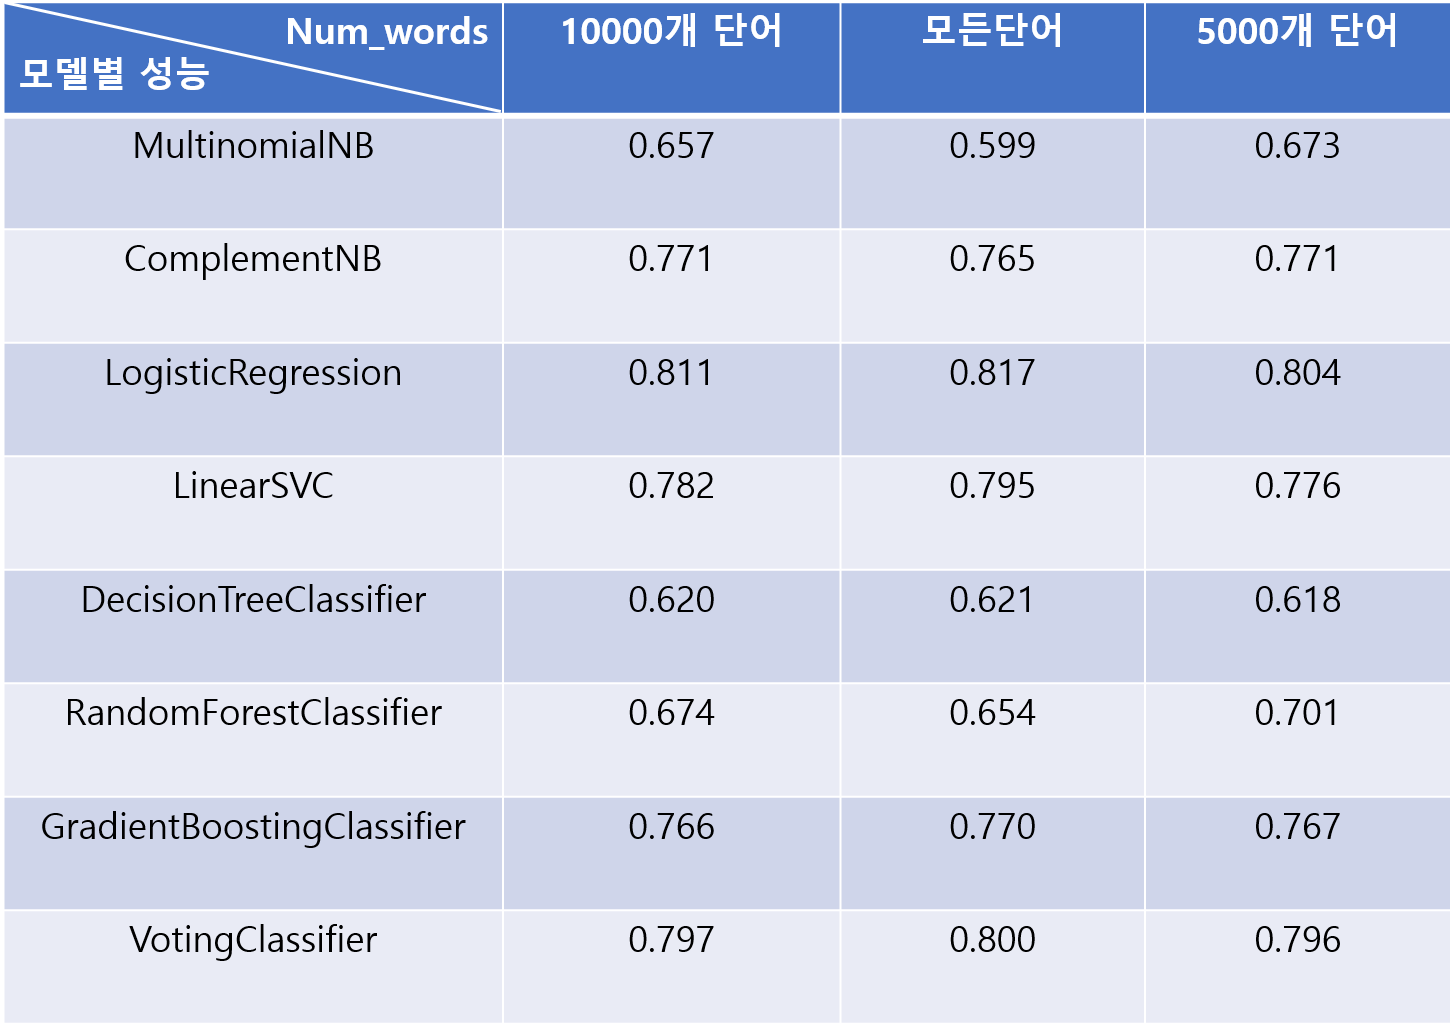

* MultinomialNB는 대체로 안정적
* ComplementNB는 모든 단어와 5,000개 단어에서 특히 좋은 성능을 보임.
* LogisticRegression은 전반적으로 높은 성능.
* LinearSVC도 높은 성능
* DecisionTreeClassifier와 RandomForestClassifier는 상대적으로 낮은 성능
* GradientBoostingClassifier는 안정적인 편이며, 성능이 고르게 나오는 편
* VotingClassifier는 다양한 방법들을 결합하여 전반적으로 높은 성능


# 3. 직접 단어 개수를 설정해서 사용
( 보팅클래스 결과가 더 잘 나오기를 바람 )

이 결과를 보면, 모든 단어를 사용했을 때 VotingClassifier의 성능이 가장 좋음.
하지만 수치의 차이가 크지 않다

일반적으로, 단어 수를 줄이면 모델의 복잡성이 감소하고 과적합 위험이 줄어들지만, 너무 많이 줄이면 중요한 정보를 잃을 수 있음.
반면, 너무 많은 단어를 사용하면 노이즈가 증가하고 계산 비용이 높아질 수 있음.


더 많은 단어 수 범위 테스트: 2,000, 3,000, 7,000, 15,000

## 3.1 단어갯수 : 2,000

In [29]:
(x_train, y_train), (x_test, y_test), word_index = get_reuters_load_data(2000)
tfidfv, tfidfv_test = transform_vector(x_train, x_test)
run_model_learn(tfidfv, tfidfv_test, y_train, y_test)

(8982, 1944)
(8982, 1944)
MultinomialNB : 나이브베이즈 - 정확도 :  0.6914514692787177
ComplementNB : 컴포넌트 나이브베이즈 - 정확도:  0.7569011576135352
LogisticRegression : 로지스틱회귀 - 정확도 :  0.7773820124666073
LinearSVC : 선형 서포트벡터 머신 - 정확도:  0.7328584149599288
DecisionTreeClassifier : 결정트리 - 정확도:  0.6255565449688335
RandomForestClassifier : 랜덤포레스트 - 정확도:  0.6954585930543188
GradientBoostingClassifier : 그라디언트부스팅 - 정확도: 0.757346393588602
      Iter       Train Loss   Remaining Time 
         1           1.4743           13.34m
         2     1391066.0896           13.32m
         3     1391065.9749           13.24m
         4 69071762683035496.0000           13.14m
         5 171277576580611034898445385567567872.0000           12.99m
         6 78629097233318221607229969534161787195228160.0000           12.84m
         7 78629097233318221607229969534161787195228160.0000           12.72m
         8 78629097233318221607229969534161787195228160.0000           12.59m
         9 786290972333182216072299695341617871

## 3.2 단어갯수 : 3,000

In [30]:
(x_train, y_train), (x_test, y_test), word_index = get_reuters_load_data(3000)
tfidfv, tfidfv_test = transform_vector(x_train, x_test)
run_model_learn(tfidfv, tfidfv_test, y_train, y_test)

(8982, 2919)
(8982, 2919)
MultinomialNB : 나이브베이즈 - 정확도 :  0.6874443455031166
ComplementNB : 컴포넌트 나이브베이즈 - 정확도:  0.7644701691896705
LogisticRegression : 로지스틱회귀 - 정확도 :  0.7880676758682101
LinearSVC : 선형 서포트벡터 머신 - 정확도:  0.7533392698130009
DecisionTreeClassifier : 결정트리 - 정확도:  0.6260017809439002
RandomForestClassifier : 랜덤포레스트 - 정확도:  0.6856634016028496
GradientBoostingClassifier : 그라디언트부스팅 - 정확도: 0.7756010685663401
      Iter       Train Loss   Remaining Time 
         1           1.4761           13.94m
         2       29810.4893           13.86m
         3 103018026703.3806           13.79m
         4 111593327959535219617691187806208.0000           13.63m
         5 1904496955476400955779467607778270076434921719903327597388087378686114846508037997135967451479015424.0000           13.51m
         6 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           13.38m
         7 2359562257671858609049731881789540250

        55 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            6.42m
        56 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            6.28m
        57 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            6.14m
        58 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            5.99m
        59 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            5.85m
        60 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            5.71m
        61

## 3.3 단어갯수 : 7,000

In [31]:
(x_train, y_train), (x_test, y_test), word_index = get_reuters_load_data(7000)
tfidfv, tfidfv_test = transform_vector(x_train, x_test)
run_model_learn(tfidfv, tfidfv_test, y_train, y_test)

(8982, 6807)
(8982, 6807)
MultinomialNB : 나이브베이즈 - 정확도 :  0.6647373107747105
ComplementNB : 컴포넌트 나이브베이즈 - 정확도:  0.7684772929652716
LogisticRegression : 로지스틱회귀 - 정확도 :  0.8067675868210151
LinearSVC : 선형 서포트벡터 머신 - 정확도:  0.782279608192342
DecisionTreeClassifier : 결정트리 - 정확도:  0.6206589492430988
RandomForestClassifier : 랜덤포레스트 - 정확도:  0.6736420302760463
GradientBoostingClassifier : 그라디언트부스팅 - 정확도: 0.7604630454140695
      Iter       Train Loss   Remaining Time 
         1           1.4702           14.80m
         2       66877.7080           14.87m
         3 889935379239589.0000           14.78m
         4 473359652203823424.0000           14.69m
         5 5684890459610620717999549779132711970496885722902391376835471286389172216935743488.0000           14.59m
         6 5684890459610620717999549779132711970496885722902391376835471286389172216935743488.0000           14.44m
         7 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000           14.2

        70 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            4.62m
        71 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            4.46m
        72 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            4.31m
        73 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            4.15m
        74 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            4.00m
        75 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            3.85m
        76 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            3.69m
        77 24726776950066592341950498667020400738329317895488375303073597129553646484008730624.0000            3.54m
        78 24726776950066592341950498667020400738329317895488375

## 3.2 단어갯수 : 15,000

In [32]:
(x_train, y_train), (x_test, y_test), word_index = get_reuters_load_data(15000)
tfidfv, tfidfv_test = transform_vector(x_train, x_test)
run_model_learn(tfidfv, tfidfv_test, y_train, y_test)

(8982, 14227)
(8982, 14227)
MultinomialNB : 나이브베이즈 - 정확도 :  0.6331255565449688
ComplementNB : 컴포넌트 나이브베이즈 - 정확도:  0.7720391807658059
LogisticRegression : 로지스틱회귀 - 정확도 :  0.8147818343722173
LinearSVC : 선형 서포트벡터 머신 - 정확도:  0.7858414959928762
DecisionTreeClassifier : 결정트리 - 정확도:  0.6193232413178985
RandomForestClassifier : 랜덤포레스트 - 정확도:  0.6714158504007124
GradientBoostingClassifier : 그라디언트부스팅 - 정확도: 0.7707034728406055
      Iter       Train Loss   Remaining Time 
         1           1.4326           15.58m
         2       81331.2398           15.56m
         3     5836811.5076           15.48m
         4 63789339395313685793847548538268197034083221504000.0000           15.30m
         5 196168839837262027401908577577888497468749556189708834227594295318514495389696.0000           15.13m
         6 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           14.98m
         7 19592378563466554644986962471065419451

        55 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            7.31m
        56 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            7.15m
        57 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            6.98m
        58 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            6.82m
        59 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            6.66m
        60 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            6.50m
        61 19592378563466554644986962471065419451420924881287390475776790084

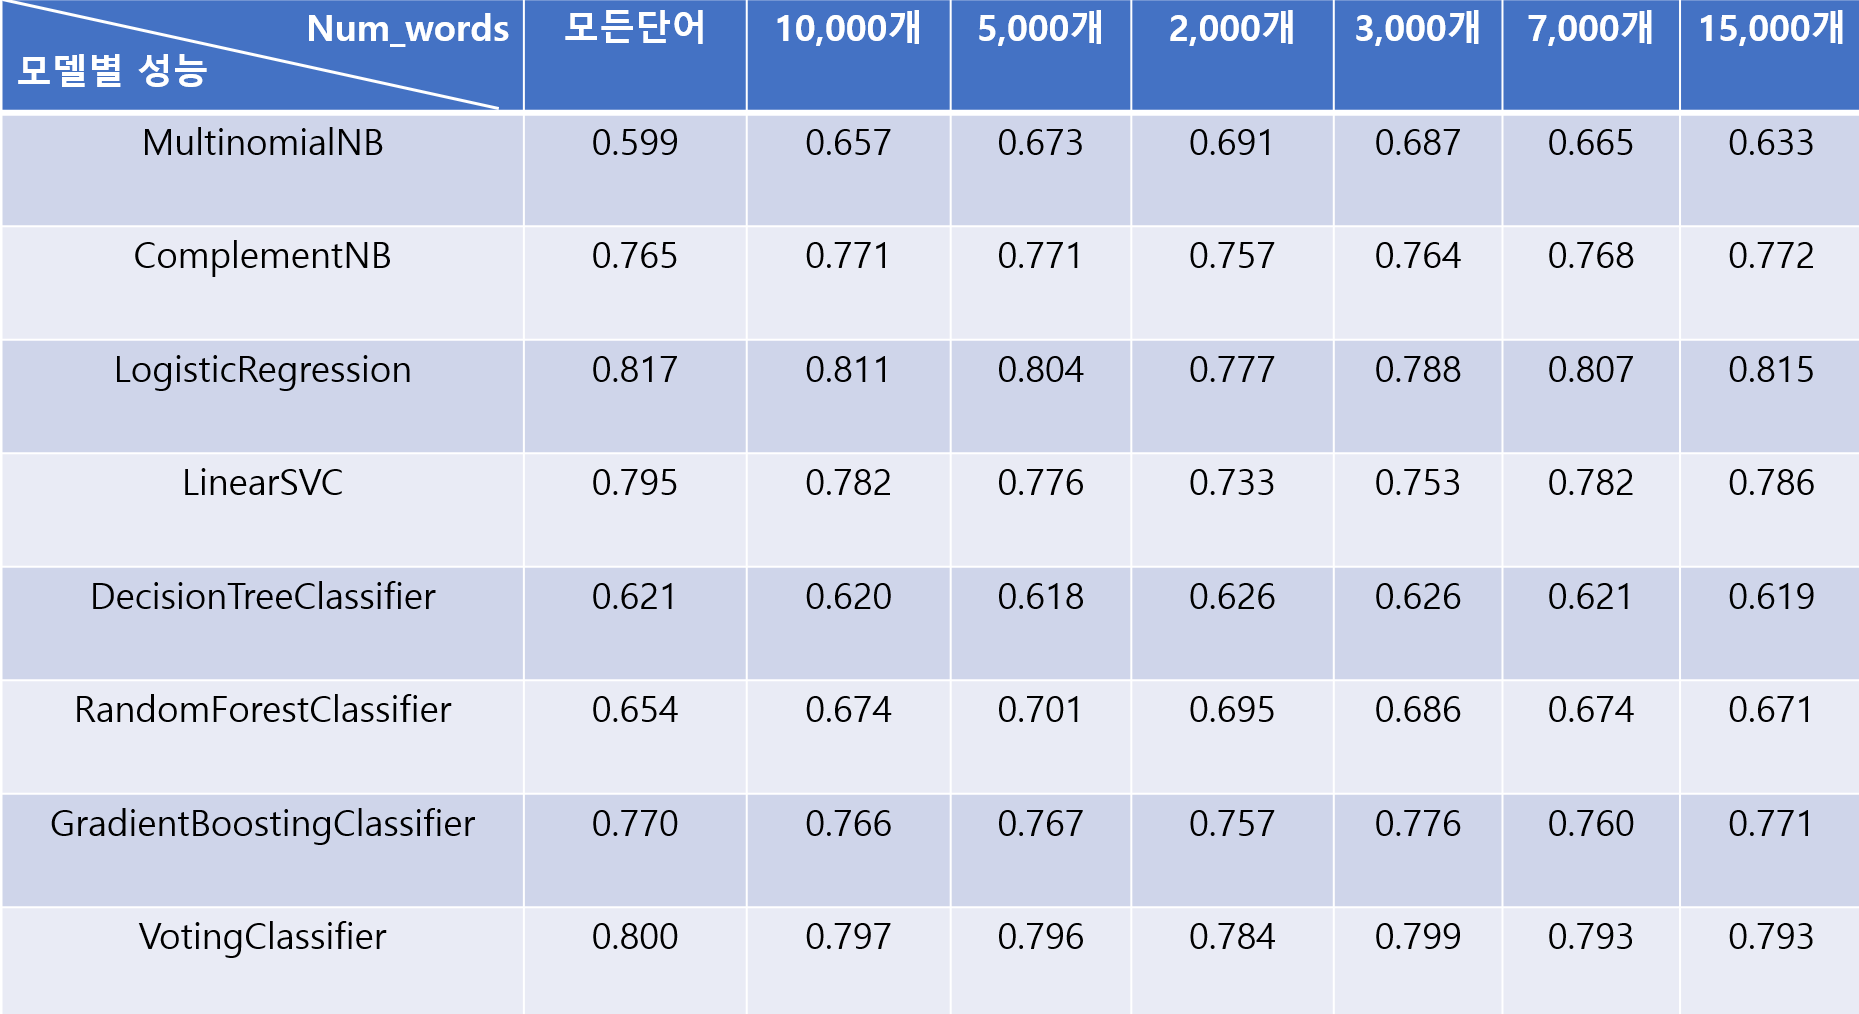

### VotingClassifier의 성능을 단어 수에 따라 정리해보면:

* 2,000 단어: 0.7836
* 3,000 단어: 0.7992
* 5,000 단어: 0.7961
* 7,000 단어: 0.7934
* 10,000 단어: 0.797
* 15,000 단어: 0.7925
* 모든 단어: 0.8001

### 분석:

1. 성능 추이: 단어 수가 증가함에 따라 성능이 전반적으로 향상되는 경향을 보임. 하지만 3,000 단어에서 예외적으로 높은 성능을 보이고, 그 이후로는 약간의 변동이 있음.

2. 최적 지점: 3,000 단어와 모든 단어를 사용했을 때 가장 높은 성능을 보임. 3,000 단어에서의 높은 성능.

3. 안정성: 5,000 에서 15,000 단어 사이에서는 성능이 비교적 안정적(0.79~0.80 사이).

4. 개별 모델 성능: LogisticRegression이 대체로 가장 좋은 성능을 보이며, 단어 수가 증가할수록 성능이 향상 됨. 
   ComplementNB와 GradientBoostingClassifier도 안정적인 성능을 보임. 시간이 부족하다면, 결과가 빨리 나오는 ComplementNB 사용을 권고.

### 의견:
1. 이 데이터셋에서는 단어 수를 줄이는 것이 반드시 성능 향상으로 이어지지 않음.

2. 계산 효율성: 3,000 단어를 사용했을 때 모든 단어를 사용한 경우와 비슷한 성능을 얻을 수 있음. 이는 계산 효율성 측면에서 매우 유리할 수 있음.

3. 모델 선택: LogisticRegression이 일관되게 좋은 성능을 보이므로, 이 모델에 더 가중치를 두는 것을 고려해볼 수 있음.

4. 과적합 vs 일반화: 모든 단어를 사용했을 때 가장 좋은 성능을 보이지만, 이는 과적합의 위험이 있을 수 있음. 반면 3,000~5,000 단어 사용 시 좋은 성능과 일반화 능력의 균형을 잡을 수 있을 것 같음.

5. 추가 실험: 2,000~5,000 단어 사이에서 더 세밀한 실험(예: 2,500, 3,500, 4,000 등)을 해보는 것도... 나쁘지 않을지도.

결론적으로, 보팅 분류기는 이 데이터셋에서는 3,000~5,000 단어를 사용하는 것이 성능과 효율성 면에서 최적의 성능을 나타냄.